Solving for a DVF: optical flow
=========================

In this example we use ImWIP to solve for an unknown DVF in the present of known images. A simple application that uses this, is optical flow: the flow of colors (or brightness levels) in a video.

There are many techniques for computing optical flow. The variational techniques all use some form of differentiated image warping, usually replaced by a regular warp with an image gradient applied to it. This example shows how exact differentiated warping gives better results.

In [1]:
import pylops
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

import imwip

We load 2 frames of a well known test video for optical flow. See <cite data-cite="barron1994performance">Barron et al. (1994)</cite> for the origin of this video.

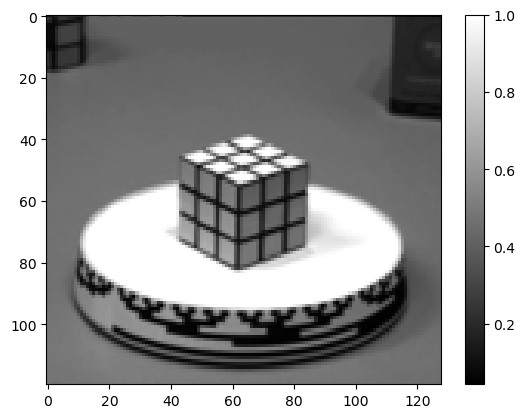

In [2]:
im1 = Image.open("im1.png").convert("L")
im2 = Image.open("im2.png").convert("L")
im1 = np.asarray(im1.resize((im1.width//2, im1.height//2)), dtype=np.float32)/255
im2 = np.asarray(im2.resize((im2.width//2, im2.height//2)), dtype=np.float32)/255
plt.imshow(im1, cmap="gray")
plt.colorbar()

We try to find the DVF $(u, v)$ that minimizes following objective function:
$$ f(u,v) = \frac{1}{2}\lVert \text{warp}(\text{im}_1, u, v) - \text{im}_2 \rVert_2^2+ \frac{a}{2} \lVert \nabla(u,v) \rVert_2^2$$
The first term enforces that this DVF deforms `im1` to look like `im2`. The second term enforces that this DVF is smooth. The parameter `a` regulates the relative importance of the terms.

In [3]:
# construct gradient operator for regularization term
G = pylops.Gradient(im1.shape, kind="forward", dtype=np.float32)
G = pylops.BlockDiag([G, G])

# weight of the regularization term
a = 5e-3

In [4]:
# objective function (for reference, only its gradient is used by the optimizer)
def f(uv):
    u, v = uv.reshape(2, *im1.shape)
    res = imwip.warp(im1, u, v) - im2
    return 1/2 * np.dot(res.ravel(), res.ravel()) + a/2 * np.linalg.norm(G @ uv)

The gradient of this objective is given by
$$\nabla f(u, v) = \left(\frac{d}{d(u,v)} \text{warp}(\text{im}_1, u, v)\right)^T (\text{warp}(\text{im}_1, u, v) - \text{im}_2) + a \nabla^T (\nabla(u, v))$$

In [5]:
# gradient of objective function
def grad_f(uv):
    u, v = uv.reshape(2, *im1.shape)
    warped = imwip.warp(im1, u, v)
    res = warped - im2
    diff_warp = imwip.diff_warping_operator_2D(im1, u, v)
    return diff_warp.T @ res.ravel() + a * (G.T @ G @ uv)

Using this gradient, we can solve for `u` and `v`:

In [6]:
# initial guess
uv0 = np.zeros(im1.size*2, dtype=np.float32)

# optimize
uv = imwip.barzilai_borwein(grad_f, uv0, max_iter=100, verbose=True)
u, v = uv.reshape(2, *im1.shape)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 798.43it/s]


Using `flow_vis`, this DVF can be visualized in color.

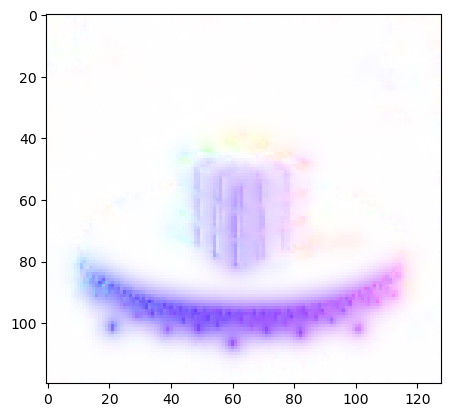

In [7]:
import flow_vis # pip install flow-vis
flow = flow_vis.flow_uv_to_colors(u, v)
plt.imshow(flow)

The direction of the flow can be read from this colormap:

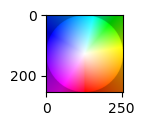

In [8]:
plt.figure(figsize=(1,1))
plt.imshow(plt.imread("colormap.png"))

Comparing exact and approximate differentated image warping
------------------------------------------------------------------------------------------
A frequently used approximation to differentiated image warping is applying an image gradient to the warped image. This can cause inaccurate results and slower convergence that exact differentiated image warping. To use this approximation for comparison, specify `approx=True`in `imwip.diff_warping_operator_2D`:

In [9]:
# approximate gradient of objective function
def approx_grad_f(uv):
    u, v = uv.reshape(2, *im1.shape)
    warped = imwip.warp(im1, u, v)
    res = warped - im2
    diff_warp = imwip.diff_warping_operator_2D(im1, u, v, approx=True)
    return diff_warp.T @ res.ravel() + a * (G.T @ G @ uv)

Now we run the optimizer again, with approximate and exact gradient, and we include a callback function that keeps track of the iterates, for a convergence plot:

In [10]:
# approx
convergence_approx = []
uv_approx = imwip.barzilai_borwein(
    approx_grad_f,
    uv0,
    max_iter=100,
    verbose=True,
    callback=lambda x: convergence_approx.append(x)
)
u_approx, v_approx = uv_approx.reshape(2, *im1.shape)

# exact
convergence_exact = []
uv = imwip.barzilai_borwein(
    grad_f,
    uv0,
    max_iter=100,
    verbose=True,
    callback=lambda x: convergence_exact.append(x)
)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 822.29it/s]


The approximation works pretty well, but two divergent pixels can be seen in the result:

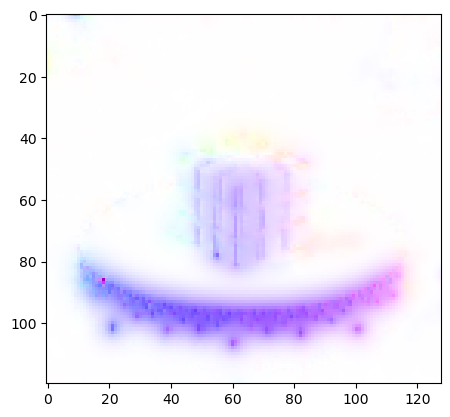

In [11]:
flow = flow_vis.flow_uv_to_colors(u_approx, v_approx)
plt.imshow(flow)

The difference is also clear in a convergence plot:

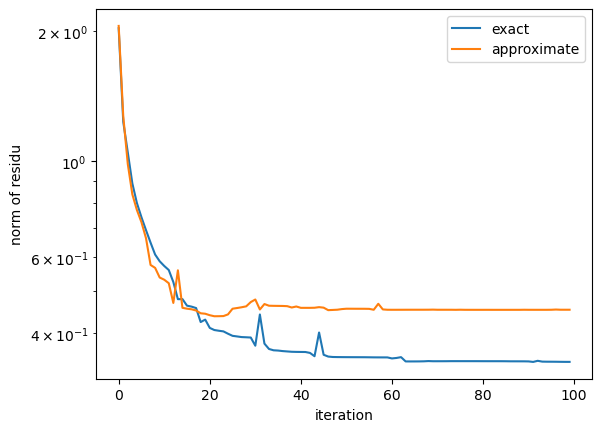

In [12]:
# compute the error of an iterate
def error(uv):
    u, v = uv.reshape(2, *im1.shape)
    return np.linalg.norm(imwip.warp(im1, u, v) - im2)

# compute all the errors
error_exact = [error(uv) for uv in convergence_exact]
error_approx = [error(uv) for uv in convergence_approx]

# error plot
plt.plot(error_exact)
plt.plot(error_approx)
plt.legend(["exact", "approximate"])
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("norm of residu")
plt.show()